In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [226]:
def square_error(data):
    return (np.subtract(data, data.mean(axis=0))**2).sum()

def dis_kurt(data):
    dis_square = (np.subtract(data, data.mean(axis=0))**2).sum(axis=1)
    out_put = (dis_square**2).mean()/(dis_square.mean()**2)
    return out_put

class KMeans():
    def __init__(self, data, seed_clusters=2, min_point=30, max_clusters=100, MCMC=False):
        self.data = np.array(data)
        self.d_n, self.dim = self.data.shape
        self.se = square_error(self.data)
        self.labels = np.zeros((self.d_n))
        self._2nd_labels = -1*np.ones((self.d_n))
        
        self.min_p = min_point
        self.max_c = max_clusters
        
        self.reset_cluster(seed_clusters)
    
    def reset_cluster(self, seed_clusters=2):
        self.clusters = np.zeros((1,self.dim))
        self.clusters[0] = self.data[np.random.randint(self.d_n)]
        if (seed_clusters>=2):
            for t in range(1, seed_clusters):
                if self.clusters.shape[0] >= self.d_n:
                    print("clusters shouldn't be more than data amounts")
                else:
                    temp_peak = self.data[np.random.randint(self.d_n)]
                    while (temp_peak in self.clusters):
                        temp_peak = self.data[np.random.randint(self.d_n)]
                    
                    self.clusters = np.vstack((self.clusters, temp_peak))
    
    def p2c(self, point):
        if len(point) != self.dim:
            print("point dimension error")
        temp_dist = (np.subtract(self.clusters, point)**2).sum(axis=1)**0.5
        return temp_dist.min()
    
    def add_cluster(self, lots = np.zeros((0,0)) ,MCMC_times = 0, MCMC_power = 1):
        if lots.shape == (0,0):
            lots = self.data
        temp_peak = lots[np.random.randint(len(lots))]
        temp_dist = self.p2c(temp_peak)
        if MCMC_times > 0:
            for t in range(MCMC_times):
                backup_peak = lots[np.random.randint(len(lots))]
                if np.random.rand()*temp_dist**MCMC_power <= self.p2c(backup_peak)**MCMC_power:
                    temp_peak = backup_peak
        
        self.clusters = np.vstack((self.clusters, temp_peak))
    
    def assign(self, only_label = True):
        self.distance = np.zeros((self.d_n, self.clusters.shape[0]))
        for c in range(self.clusters.shape[0]):
            temp_relate = np.subtract(self.data, self.clusters[c])
            self.distance[:,c] = (0.0001 + (temp_relate**2).sum(axis=1))**0.5
        
        temp_dis_sort = np.argsort(self.distance, axis=1)
        self.labels = temp_dis_sort[:, 0]
        
        if (not only_label):
            if self.clusters.shape[0] >=2:
                self._2nd_labels = temp_dis_sort[:, 1]
            else:
                self._2nd_labels = -1*np.ones((self.d_n))
            
            self.c_se = np.zeros((self.clusters.shape[0]))
            self.c_std = np.zeros((self.clusters.shape[0]))
            self.c_kurt = np.zeros((self.clusters.shape[0]))
            for c in range(self.clusters.shape[0]):
                if (self.labels == c).sum() > 0:
                    self.c_se[c] = square_error(np.compress(self.labels == c, self.data, axis=0)) 
                    self.c_std[c] = self.c_se[c]/(self.labels == c).sum()
                    self.c_kurt[c] = dis_kurt(np.compress(self.labels == c, self.data, axis=0)) 
            
            self.c_std = np.sqrt(0.0001 + self.c_std)
            self.c_dist_cfd = np.zeros((self.clusters.shape[0], 10))
            self.c_fm = np.zeros((self.clusters.shape[0])) # foreign matter
            for c in range(self.clusters.shape[0]):
                temp_c_d = np.subtract(self.data, self.clusters[c])
                temp_c_d = np.sqrt(0.0001+(temp_c_d**2).sum(axis=1))/ self.c_std[c]
                if (self.labels == c).sum()>=2:
                    self.c_fm[c] = ((temp_c_d<2.)*(self.labels != c)).sum()/(self.labels == c).sum()
                
                temp_c_d_c = np.compress(self.labels == c, temp_c_d)
                
                for i in range(10):
                    self.c_dist_cfd[c][i] = (temp_c_d_c < ((i+1)/10)).sum()
                
                self.c_dist_cfd[c] /= (self.labels == c).sum() + 0.0001
    
    def single_fit(self, only_label=True):
        for c in range(self.clusters.shape[0]):
            if (self.labels == c).sum() > 0:
                self.clusters[c] = np.compress(self.labels == c, self.data, axis=0).mean(axis=0)
        
        self.assign(only_label)
    
    def fit(self, max_times=10):
        for t in range(max_times):
            temp_pre_lables = self.labels
            self.single_fit()
            if np.abs(self.labels - temp_pre_lables).sum() == 0:
                break
        
        self.single_fit(only_label=False)
    
    def drop_cluster(self, c):
        self.clusters = np.vstack((self.clusters[:c], self.clusters[c+1:]))


[0, 0] 1
[-6.55277808 -1.05226138] 0.7039427359527064
[-9.11825201  3.67727493] 0.112595717368461


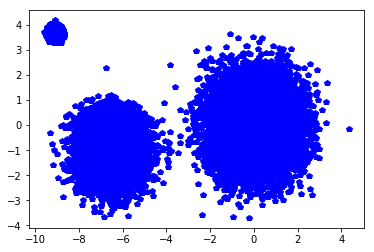

In [248]:
foo = np.random.normal(0,1,(10000,2))
print([0,0],1)

for t in range(1,3):
    c = np.random.rand((2))*40 - 20
    s = np.random.rand() + 0.1
    foo = np.vstack((foo, np.random.normal(0,s, (10000,2)) + c))
    print(c,s)

plt.plot(foo.T[0], foo.T[1] , "bp")
plt.show()

In [96]:
k_mean = KMeans(foo, seed_clusters=1)
k_mean.fit()
print (k_mean.c_se.sum()/k_mean.se)
for c in range(1,4):
    k_mean.add_cluster(MCMC_times=10)
    k_mean.fit(20)
    print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se)

print(k_mean.clusters)

1.0
0.176621199864 2
0.0467785770026 3
0.00925386521768 4
[[  0.02092978  -0.02441536]
 [ 16.99849807 -17.28980479]
 [-11.73284023  -6.1944784 ]
 [ 12.83046749 -11.49708594]]


t =  1
2 0.415785254181 se large
3 0.0501319792329 se large
4 0.049997069737 outlier large
5 0.0499001481825 central empty level 1
4 0.0499971131015 clus kill
3 0.0501319792329 clus kill
t =  2
4 0.0499938105358 outlier large
3 0.0501319792329 clus kill
t =  3
4 0.0499959559327 outlier large
5 0.0498996412137 central empty level 1
4 0.0499921557515 clus kill
3 0.0501319792329 clus kill
t =  4
4 0.0499918515797 outlier large
3 0.0501319792329 clus kill
t =  5
4 0.0499916299528 outlier large
5 0.0498998477996 central empty level 1
4 0.0499917282648 clus kill
3 0.0501319792329 clus kill
t =  6
4 0.0499934068399 outlier large
5 0.0498993485822 central empty level 1
6 0.0498569690851 central empty level 1
5 0.0498993640054 clus kill
4 0.0499932725109 clus kill
3 0.0501319792329 clus kill
t =  7
4 0.0499915774675 outlier large
5 0.0498998446193 central empty level 1
6 0.0498565975224 central empty level 1
5 0.0498998256901 clus kill
4 0.0499917201472 clus kill
3 0.0501319792329 clus kill
t =

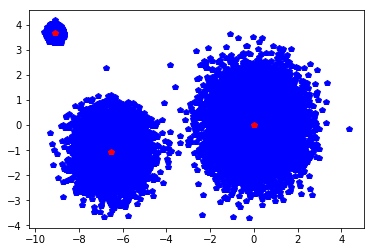

In [249]:
k_mean = KMeans(foo, seed_clusters=1)
k_mean.fit()

for t in range(20):
    print("t = ", t+1)
    round_down = False
    
    while (k_mean.c_se.sum()/k_mean.se > 0.2):
        k_mean.add_cluster(MCMC_times=10)
        k_mean.fit()
        print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "se large")
    
    for c in range(k_mean.clusters.shape[0]):
        if k_mean.c_kurt[c] > 2.5:
            k_mean.add_cluster(lots=np.compress(k_mean.labels == c, k_mean.data, axis=0), MCMC_times=10)
            k_mean.fit()
            print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "outlier large")
            round_down = True
    
    for c in range(k_mean.clusters.shape[0]):
        for l in range(10):
            if k_mean.c_dist_cfd[c][l] < 0.8*0.5*(((l+1)/10)**2):
                k_mean.add_cluster(lots=np.compress(k_mean.labels == c, k_mean.data, axis=0), MCMC_times=10)
                k_mean.fit()
                print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "central empty level", l+1)
                round_down = True
                break
    
    kiling = True
    while kiling:
        for c in range(k_mean.clusters.shape[0]):
            if k_mean.c_fm[c] > 0.8:
                k_mean.drop_cluster(c)
                k_mean.fit()
                print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "clus kill")
                break
                
            if c == (k_mean.clusters.shape[0]-1):
                kiling = False




plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()

(51, 2)

In [225]:
k_mean.c_kurt

array([ 2.03775184,  1.55205297,  2.05817609,  2.00522185,  1.73180724,
        1.91252577,  1.87866471,  1.61301695,  1.93293163,  1.51981178,
        1.90691481,  3.5648273 ,  2.19158838,  3.37972324,  2.38886392])

In [179]:
k_mean.clusters

array([[ -6.04003616, -17.25278967],
       [-19.28667328,   6.95255462],
       [ 16.90977469,  11.59214431],
       [ -0.37339949,  -0.65394102],
       [  2.48468875, -18.68920762],
       [-17.41706018,  -4.61499276],
       [  3.71926191,  19.10964371]])

In [64]:
np.sqrt(k_mean.c_se[3]/(k_mean.labels == 3).sum())

1.1099787209994871

In [190]:
def erf(x, Taylor=100):
    temp = x*np.sqrt(0.5)
    output = 0
    for t in range(Taylor+1):
        output += temp/(2*t+1)
        temp *= -(x**2)/(2*t+2)
    
    return 2*output/np.sqrt(np.pi)

In [203]:
for i in range(1,6):
    print(erf(0.2*i))

0.158519418878
0.310843483221
0.4514937645
0.576289202833
0.682689492137


In [24]:
for d in range(1, 10):
    print((d/(d+2))**(d/2))

0.5773502691896257
0.5
0.46475800154489
0.4444444444444444
0.43120115037169215
0.421875
0.4149486509808663
0.4096000000000001
0.4053444297059028


In [64]:
foo = np.arange(6).reshape(3,2)